In [314]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix


In [315]:
df = pd.read_csv('./data/WineQT.csv')
df.set_index('Id')


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
Id,,,,,,,,,,,,
0,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
1,7.8,0.880,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5
2,7.8,0.760,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5
3,11.2,0.280,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6
4,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
...,...,...,...,...,...,...,...,...,...,...,...,...
1592,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6
1593,6.8,0.620,0.08,1.9,0.068,28.0,38.0,0.99651,3.42,0.82,9.5,6
1594,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5


In [316]:
class TierColumnAdder:

    def __init__(self, tier_col_name='quality'):
        self.tier_col_name = tier_col_name

    def fit(self, X, **fit_params):
        return

    def transform(self, X):
        series = X[self.tier_col_name]
        self.avg_qual = series.mean()
        self.top_tier = series.quantile(.95)
        self.bottom_tier = series.quantile(.01)
        self.min = series.min()
        self.max = series.max()
        above_avg = X[self.tier_col_name] >= self.avg_qual
        top = X[self.tier_col_name] >= self.top_tier
        bot = X[self.tier_col_name] <= self.bottom_tier
        min = X[self.tier_col_name] == self.min
        max = X[self.tier_col_name] == self.max
        return X.assign(above_avg=above_avg, top_tier=top, bottom_tier=bot, worst=min, best=max)

    def fit_transform(self, X, y=None, **fit_params):
        self.fit(X)
        return self.transform(X)


In [317]:
class OneScaler:

    def fit(self, X, **fit_params):
        return

    def transform(self, X):
        self.centered = X - X.mean()
        self.v_min = self.centered.min().abs()
        self.v_max = self.centered.max()
        self.above_mean = self.centered >= 0
        self.scaled_high = self.centered[self.above_mean] / self.v_max
        self.scaled_low = self.centered[~self.above_mean] / self.v_min
        self.combined = self.scaled_high.fillna(self.scaled_low)
        return self.combined

    def fit_transform(self, X, y=None, **fit_params):
        self.fit(X)
        return self.transform(X)


In [318]:
class ColumnSelector:

    def __init__(self, col_names):
        self.col_names = col_names

    def fit(self, X, **fit_params):
        return
        
    def transform(self, X):
        return X[self.col_names]

    def fit_transform(self, X, y=None, **fit_params):
        self.fit(X)
        return self.transform(X)

In [319]:
columns = ['alcohol', 'sulphates', 'citric acid', 'fixed acidity', 'chlorides', 'density',
           'total sulfur dioxide', 'volatile acidity', 'above_avg', 'top_tier', 'bottom_tier', 'best', 'worst']


In [320]:
pipeline = Pipeline([('col_adder', TierColumnAdder()), ('selector', ColumnSelector(
    columns)), ('scaler', OneScaler()), ('poly', PolynomialFeatures(degree=2, include_bias=True)), ('estimator', RandomForestClassifier(random_state=42))])
#, ('scaler', OneScaler()), ('poly', PolynomialFeatures(degree = 2, include_bias = True))
#, ('estimator', RandomForestClassifier(random_state=42))


In [307]:
X_trans = pipeline.fit_transform(df)

ValueError: This RandomForestClassifier estimator requires y to be passed, but the target y is None.

In [264]:
X_trans


array([[ 1.        , -0.51031075, -0.29815522, ...,  1.        ,
         1.        ,  1.        ],
       [ 1.        , -0.31443505,  0.01660757, ...,  1.        ,
         1.        ,  1.        ],
       [ 1.        , -0.31443505, -0.0235203 , ...,  1.        ,
         1.        ,  1.        ],
       ...,
       [ 1.        ,  0.01298565, -0.23712524, ...,  1.        ,
         1.        ,  1.        ],
       [ 1.        ,  0.17001066,  0.07620711, ...,  1.        ,
         1.        ,  1.        ],
       [ 1.        , -0.11855935,  0.0389574 , ...,  1.        ,
         1.        ,  1.        ]])

In [301]:

pn = PolynomialFeatures(degree=2, include_bias=True)
poly = pn.fit_transform(OneScaler().transform(X_trans))


AttributeError: 'numpy.float64' object has no attribute 'abs'

In [35]:
#df_tiers = TierColumnAdder().fit_transform(df)

In [121]:
corr_matrix = pd.DataFrame( X_trans).assign(y=df.quality).corr()
corr_matrix
#corr_matrix['quality'].sort_values(ascending=False)


,0,1,2,3,4,5,6,7,8,9,...,96,97,98,99,100,101,102,103,104,y
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,1.000000,0.159635,0.056271,-0.114794,-0.370410,-0.472379,-0.208926,-0.231119,0.451985,...,-0.328652,-0.352679,-0.369449,NaN,-0.035957,0.032647,NaN,-0.095797,NaN,0.483564
2,NaN,0.159635,1.000000,0.317394,0.178159,0.125990,0.175398,0.025773,-0.322542,0.326472,...,-0.183731,-0.221716,-0.230316,NaN,0.017855,0.068160,NaN,-0.055255,NaN,0.345434
3,NaN,0.056271,0.317394,1.000000,0.626002,0.169947,0.348464,0.049100,-0.577693,0.133255,...,-0.151556,-0.201089,-0.212507,NaN,0.042863,0.103500,NaN,-0.059370,NaN,0.220451
4,NaN,-0.114794,0.178159,0.626002,1.000000,0.281994,0.681167,-0.107051,-0.262949,0.068668,...,-0.076623,-0.104993,-0.108036,NaN,0.026813,0.053581,NaN,-0.023533,NaN,0.104222
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101,NaN,0.032647,0.068160,0.103500,0.053581,0.009557,0.005219,0.030121,-0.134645,0.188064,...,0.376685,-0.065202,-0.070822,NaN,0.766882,1.000000,NaN,-0.024155,NaN,0.354715
102,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
103,NaN,-0.095797,-0.055255,-0.059370,-0.023533,0.043068,0.044236,0.094834,0.019903,-0.051738,...,0.306050,-0.052976,0.341064,NaN,0.623077,-0.024155,NaN,1.000000,NaN,-0.170327
104,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [226]:
#columns = ['alcohol', 'sulphates', 'citric acid', 'fixed acidity', 'chlorides', 'density',  'total sulfur dioxide', 'volatile acidity', 'above_avg', 'top_tier', 'bottom_tier', 'best', 'worst']
y_raw = df['quality']
#X_raw = X_trans[columns]
#X_raw


In [39]:
#scaler = OneScaler()
#X_raw_scaled = scaler.fit_transform(X_raw)
#X_raw_scaled

,alcohol,sulphates,citric acid,fixed acidity,chlorides,density,total sulfur dioxide,volatile acidity,above_avg,top_tier,bottom_tier,best,worst
0,-0.510311,-0.298155,-1.000000,-0.245509,-0.145899,0.153686,-0.298504,0.160835,-1.0,-1.0,-1.0,-1.0,-1.0
1,-0.314435,0.016608,-1.000000,-0.137725,0.021118,0.009999,0.086740,0.332482,-1.0,-1.0,-1.0,-1.0,-1.0
2,-0.314435,-0.023520,-0.850949,-0.137725,0.009669,0.038736,0.033261,0.218051,-1.0,-1.0,-1.0,-1.0,-1.0
3,-0.314435,-0.237125,0.398608,0.380673,-0.159245,0.182423,0.057944,-0.611026,1.0,-1.0,-1.0,-1.0,-1.0
4,-0.510311,-0.298155,-1.000000,-0.245509,-0.145899,0.153686,-0.298504,0.160835,-1.0,-1.0,-1.0,-1.0,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1138,0.125146,0.068757,-0.515583,-0.541916,-0.145899,-0.148701,-0.148183,-0.051876,1.0,-1.0,-1.0,-1.0,-1.0
1139,-0.461342,0.120907,-0.701897,-0.407186,-0.252662,-0.033093,-0.198290,0.084547,1.0,-1.0,-1.0,-1.0,-1.0
1140,0.012986,-0.237125,-0.701897,-0.568862,0.005853,-0.274820,-0.047970,0.065475,-1.0,-1.0,-1.0,-1.0,-1.0
1141,0.170011,0.076207,-0.627372,-0.649701,-0.332734,-0.241789,0.020920,0.017795,1.0,-1.0,-1.0,-1.0,-1.0


In [125]:
#corr_matrix = X_raw_scaled.assign(y=y_raw).corr()
#corr_matrix


,alcohol,sulphates,citric acid,fixed acidity,chlorides,density,total sulfur dioxide,volatile acidity,above_avg,top_tier,bottom_tier,best,worst,y
alcohol,1.000000,0.159635,0.056271,-0.114794,-0.370410,-0.472379,-0.208926,-0.231119,0.451985,0.386680,-0.051984,0.145830,-0.054948,0.483564
sulphates,0.159635,1.000000,0.317394,0.178159,0.125990,0.175398,0.025773,-0.322542,0.326472,0.245222,-0.084441,0.097954,-0.054196,0.345434
citric acid,0.056271,0.317394,1.000000,0.626002,0.169947,0.348464,0.049100,-0.577693,0.133255,0.223777,-0.110635,0.092874,-0.038112,0.220451
fixed acidity,-0.114794,0.178159,0.626002,1.000000,0.281994,0.681167,-0.107051,-0.262949,0.068668,0.109408,-0.048827,0.026603,0.001493,0.104222
chlorides,-0.370410,0.125990,0.169947,0.281994,1.000000,0.451139,0.100656,0.151568,-0.172378,-0.189982,-0.000216,-0.063655,0.021604,-0.199399
density,-0.472379,0.175398,0.348464,0.681167,0.451139,1.000000,0.070525,0.037764,-0.156527,-0.150851,0.009363,-0.073639,0.035614,-0.177657
total sulfur dioxide,-0.208926,0.025773,0.049100,-0.107051,0.100656,0.070525,1.000000,0.102120,-0.175605,-0.134977,-0.049518,-0.077321,-0.054604,-0.161807
volatile acidity,-0.231119,-0.322542,-0.577693,-0.262949,0.151568,0.037764,0.102120,1.000000,-0.334327,-0.339602,0.168692,-0.092040,0.111795,-0.414134
above_avg,0.451985,0.326472,0.133255,0.068668,-0.172378,-0.156527,-0.175605,-0.334327,1.000000,0.368545,-0.205002,0.109241,-0.079233,0.846007
top_tier,0.386680,0.245222,0.223777,0.109408,-0.189982,-0.150851,-0.134977,-0.339602,0.368545,1.000000,-0.075552,0.296413,-0.029201,0.720433


In [311]:
#from sklearn.preprocessing import PolynomialFeatures
#poly_features = PolynomialFeatures(degree=2, include_bias=True)
#x_poly = pd.DataFrame(poly_features.fit_transform(transformed))


In [321]:
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
X_train, X_test, y_train, y_test = train_test_split(
    df, y_raw, test_size=0.2, random_state=42)


In [323]:
pipeline.fit(X_train, y_train)
y_train_pred = pipeline.predict(X_train)

In [281]:
#from sklearn.ensemble import RandomForestClassifier

#forest_clf = RandomForestClassifier(random_state=42)
#forest_clf.fit(X_train, y_train)


RandomForestClassifier(random_state=42)

In [282]:
#y_train_pred = cross_val_predict(forest_clf, X_train, y_train, cv=3)


array([[  6,   0,   0,   0,   0,   0],
       [  0,  27,   0,   0,   0,   0],
       [  0,   0, 387,   0,   0,   0],
       [  0,   0,   0, 363,   0,   0],
       [  0,   0,   0,   0, 117,   0],
       [  0,   0,   0,   0,   0,  14]], dtype=int64)

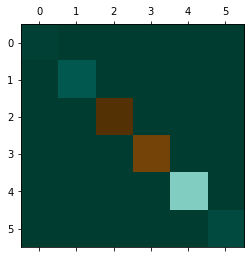

In [324]:
from sklearn.metrics import confusion_matrix
conf_mx = confusion_matrix(y_train, y_train_pred)
plt.matshow(conf_mx, cmap=plt.cm.BrBG_r)
conf_mx


In [325]:
#y_pred = forest_clf.predict(X_test)
scores = cross_val_score(pipeline, X_train, y_train,
                         cv=3, scoring="accuracy")
scores


array([1., 1., 1.])

In [326]:
val_scores = cross_val_score(
    pipeline, X_test, y_test, cv=3, scoring='accuracy')
val_scores


C:\Users\c3a1r\anaconda3\envs\ML\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


array([1.        , 0.98684211, 0.92105263])